<a href="https://colab.research.google.com/github/leonardoLavagna/Inside-Rijndael/blob/main/Rijndael_S_Box.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inside Rijndael

## Introduction 

Let $B_8$ be the set of sequences of 8 bits. We can think of $B_8$ as $\{0,1,\dots, 255\}$ or as the set of pairs of hex characters. A **Rijndael S-Box** is a particular bijection $S: B_8\to B_8$. More precisely $S(x)=Ai(x)+b$ is the composition of the multiplicative inversion $i(x)$ in the field $F_{2^8}$ with an affine transformation. To construct such an S-Box we will need to:


*   Establish a bijection $N\to Z_2[x]$ from the set of non negative integers and the ring of polinomials with coefficients in the field $Z_2$;
*   Find suitable arithmetic operations in $N$ that can be translated in meaningful operations in $Z_2[x]$ (e.g. the multiplication of integers needs to be translated into a suitable multiplication of polynomials);
* Define the inversion wrt the multiplication found in the previous point;
* Define the affine transformation $x\to Ax+b$ to compose with the inversion found in the previous point.

### 1. Bijection $N\to Z_2[x]$. 
We will think of $B_8$ as the set of couples of hex characters. 

*Example 1.1 .* When we will have a Rijndael S-Box $S$ we will have as input $x$ a couple of hex characters and as output another couple of hex characters. In this sense writing $S(9a)=b8$ means that $S$ maps $(90,0a)$ to $(0b,80)$.

Consider the binary expansion of $x\in N$, that is $$x=\sum_{i=1}^m b_i2^i$$ where $b_i\in \{0,1\}$ for evry $i=1,2,\dots, m$. The polynomial associated to $x$ in $Z_2[x]$ is $$f_x(t)=\sum_{i=0}^mb_it^i$$ where the degree $deg(f_x(t))$ of $f_x(t)$ is equal to the number of bits of $x$ up to one, that is $deg(f_x(t))=\#bits(x) +1$.

The map $x\to f_x$ is the wanted bijection. There is more: it is an isomprhism of commutative rings.

*Example 1.2 .* If $x=(201)_{10}=(11001001)_2$ then $f_x(t)=t^7+t^6+t^3+1$.

## 2. Arithmetic operations
**Proposition 2.1 .** If $<<$ denote the *left shift operator* then $$f_{x<<k}(t)=t^kf_x(t)$$

*Proof .* Iterating through the case $$f_{x<<1}(t)=\sum_{i=1}^{m+1}b_{i-1}t^i=t\sum_{i=1}^mb_{i-1}t^{i-1}=tf_x(t) $$ the conclusion follows easily.

**Proposition 2.2 .** The multiplication in $Z_2[x]$ satisfy $$f_x(t)f_y(t)=\sum_{\{i\ : \ b_i=1\}}f_{y<<i}(t) $$

*Proof .* By definition $$f_x(t)f_y(t)=\sum_{i=1}^mb_it^if_y(t)$$ Since $t^if_y(t)=f_{y<< i}(t)$ the conclusion follows from the previous result. 

*Example 2.1 .* If $x=(201)_{10}=(11001001)_2$ and $y=(102)_{10}=(01100110)_2$ then $f_x(t)f_y(t)=t^{13}+t^{11}+t^8+t^7+t^6+t^4+t^2+t$.

**Corollary .** If $z=\bigoplus x_i$ then $f_z(t)=\sum_{i}f_{x_i}(t)$. In particular if $z=\bigoplus_{\{i \ : \ b_i=1\}} y<< i$ then $$f_z(t)=\sum_{\{i \ : \ b_i=1\}}f_{y<< i}(t)=f_x(t)f_y(t)$$

To find the number $z$ such that it is associated to the product of the polynoials $f_x$ and $f_y$ we can implement in code the previous Corollary.

In [1]:
def multiply_ints_as_polynomials(x, y):
  """
    Inputs: x, y non-negative integers
    Outputs: z, the integer associated to f_xf_y
  """
  z = 0
  while x != 0:
    if x & 1 == 1:
      z ^= y
      y <<= 1
      x >>= 1
  return z

We will now implement the [extended euclidean algorithm](https://en.wikipedia.org/wiki/Extended_Euclidean_algorithm#Polynomial_extended_Euclidean_algorithm), with a particular focus on the reduction of polynomials in $Z_2[x]$. 

*Example 2.2 .* If $x=(10100111010110)_2=(10710)_10$ then $f_x(t)=t^{13}+t^{11}
+t^8+t^7+t^6+t^4+t^2+t$. Lets reduce $f_x(t)$ by $f_y(t)= t^8+t^4+t^3+t+1$ that is associated to $y=(100011011)_2=(283)_{10}$. We need to iteratively compute $f_x(t)-t^{deg(f_x)+deg(f_y)}f_y(t)$ untill $deg(f_x)-deg(f_y)=deg(f_x)+deg(f_y) \leq 0$. The first step in the case we are examining is $f_x(t)+t^5f_y(t)=t^11+t
^9+t^7+t^5+t^4+t^2+t$, the second step is given by $f_x(t)+t^3f_y(t)=t^9+t^6+t^5+t^3+t^2+t$, and so on... The last step will give $t^6+t^4+t^3$ whic is associated to $(1011000)_2=(88)_{10}$.

In [2]:
def number_bits(x):
  """
    Inputs: x, a non-negative integer
    Outputs: nb, the number associated to the last step of the extended 
             euclidean algorithm
  """
  nb = 0
  while x != 0:
    nb += 1
    x >>= 1
  return nb


def mod_int_as_polynomial(x, m):
	nbm = number_bits(m)
	while True:
		nbx = number_bits(x) 
		if nbx < nbm:
			return x
		mshift = m << (nbx - nbm)
		x ^= mshift

*Remark 2.1 .* The previous code can be used, recursively, to implement the multiplication in the fields of the form $F_{2^n}$, by defining the multiplication as `mod_int_as_polynomial(multiply_ints_as_polynomials(x,y),z)`.

## 3. Rijndael multiplication and inversion
We will now define two operations that will make $B_8$ a finite field isomorphic to $F_{2^8}$.

**Definition 3.1 .** The operations in $B_8$ are:


*   the **addition** $\oplus$ given by XOR
*   the **multiplication** $\star$ given by the function introduced in Remark 2.1 where $z=(283)_{10}=(100011011)_2$ is fixed.

*Remark 3.1 .* The associated polynomial to the previously fixed value of $z$ is $t^8+t^4+t^3+t+1$ which is an irreducible polynomial, hence the prime ideal $(f_z(t))$ is also maximal and the quotient $F_{2}[t]/(f_z(t))$ is a field isomorfic to $F_{2^8}$.

*Example 3.1 .* Recalling Example 2.1 and Example 2.2 whe have that $201\star102=88$.

We will now implement the multiplication $\star$ and calculate brute-forcefully the multiplicative inverses.

In [3]:
def rijndael_multiplication(x, y):
  """
    Inputs: x,y, non-negative integers
    Outputs: the Rijndael multiplication of x and y

    Remark: The value m is fixed and equal to (283)_10
  """
  z = multiply_ints_as_polynomials(x, y)
  m = int('100011011', 2)
  return mod_int_as_polynomial(z, m)


def rijndael_inverse(x):
  """
    Inputs: x a non-negative integer
    Outputs: the multiplicative inverse wrt rijndael multiplication

    Remark: the inverse is found via brute-force search
  """
  if x == 0:
    return 0
  for y in range(1, 256):
    if rijndael_multiplication(x, y) == 1:
      return y

## 4. Affine transformations

As stated in the Introduction, the Rijndael S-Box is given by an affine transformation $Ai(x)+b$ where $i(x)$ is the inverse of $x$ calculated by the function `rijndael_inverse(x)` in the previous section. To get such an S-Box we will now need to implement the dot product and the mapping $x\to Ax+b$. We can think that the $8\times 8$ matrix $A$ with entries in $F_2$ is associated to a $64-$bit integer and the column vectors $x$ and $b$ associated to $8-$bit integers.

In [4]:
def dot_product(x, y):
  """
    Inputs: x,y, non-negative 8-bit integers as column vectors
    Outputs: the dot product of x times y
  """
  z = x & y
  dot = 0  
  while z != 0:
    dot ^= z & 1
    z >>= 1
  return dot 

def affine_transformation(A, x, b):
  """
    Inputs: A is a 64-bit integer that represents as a 8 by 8 matrix of 0's and 1's
            x and b are 8-bit integers, considered as column vectors
    Outputs: the affine transformation A * x + b
  """
  y = 0
  for i in reversed(range(8)):
    row = (A >> 8 * i) & 0xff 
    bit = dot_product(row, x)
    y ^= (bit << i)
  return y ^ b


In the literature $A$ is a fixed standard matrix, see: https://csrc.nist.gov/csrc/media/publications/fips/197/final/documents/fips-197.pdf for more details. Here for implementation issues we will need to "flip" $A$ so that for column vectors the most significant bits are at the top (see the following figure).

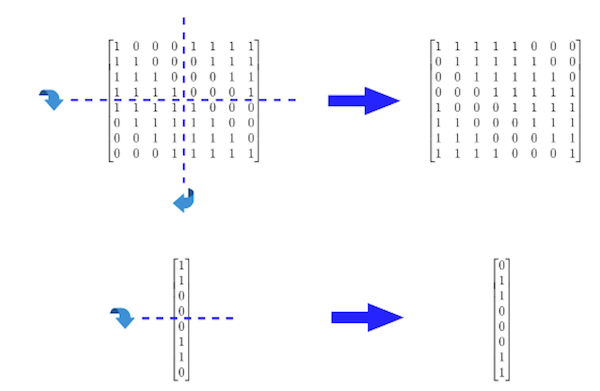

## 5. Rijndael S-Box
In conclusion we can now implement and print the Rijndael S-Box

In [20]:
def rijndael_sbox(x):
  """
    Inputs: x a non negative integer
    Outputs: the rijndael s-box A*i(x)+b

    Remark. A is fixed 
  """
  xinv = rijndael_inverse(x)
  A = int('1111100001111100001111100001111110001111110001111110001111110001', 2)
  b = int('01100011', 2)
  return affine_transformation(A, xinv, b)

def print_rijndael_sbox(inverse):
  if inverse==False:
    for row in range(16):
      for col in range(16):
        x = 16 * row + col
        hexstring = format(rijndael_sbox(x), "02x")
        print(hexstring, end=' ')
      print()	
  elif inverse==True:
    for row in range(16):
      for col in range(16):
        x = 16 * row + col
        hexstring = format(rijndael_inv_sbox(x), "02x")
        print(hexstring, end=' ')
      print()

In [21]:
print_rijndael_sbox(False)

63 7c 77 7b f2 6b 6f c5 30 01 67 2b fe d7 ab 76 
ca 82 c9 7d fa 59 47 f0 ad d4 a2 af 9c a4 72 c0 
b7 fd 93 26 36 3f f7 cc 34 a5 e5 f1 71 d8 31 15 
04 c7 23 c3 18 96 05 9a 07 12 80 e2 eb 27 b2 75 
09 83 2c 1a 1b 6e 5a a0 52 3b d6 b3 29 e3 2f 84 
53 d1 00 ed 20 fc b1 5b 6a cb be 39 4a 4c 58 cf 
d0 ef aa fb 43 4d 33 85 45 f9 02 7f 50 3c 9f a8 
51 a3 40 8f 92 9d 38 f5 bc b6 da 21 10 ff f3 d2 
cd 0c 13 ec 5f 97 44 17 c4 a7 7e 3d 64 5d 19 73 
60 81 4f dc 22 2a 90 88 46 ee b8 14 de 5e 0b db 
e0 32 3a 0a 49 06 24 5c c2 d3 ac 62 91 95 e4 79 
e7 c8 37 6d 8d d5 4e a9 6c 56 f4 ea 65 7a ae 08 
ba 78 25 2e 1c a6 b4 c6 e8 dd 74 1f 4b bd 8b 8a 
70 3e b5 66 48 03 f6 0e 61 35 57 b9 86 c1 1d 9e 
e1 f8 98 11 69 d9 8e 94 9b 1e 87 e9 ce 55 28 df 
8c a1 89 0d bf e6 42 68 41 99 2d 0f b0 54 bb 16 


The inverse S-box is simply the S-box run in reverse: if $y=Ai(x)+b$ then $S^{-1}(y)=i(A^{-1}y-b)=i(A^{-1}y+b)$.

In [32]:
def rijndael_inv_sbox(x):
  """
    Inputs: x a non negative integer
    Outputs: the rijndael inverse s-box

    Remark. A is fixed 
  """
  xinv = rijndael_inverse(x)
  A = int('0101001000101001100101000100101000100101100100100100100110100100', 2)
  b = int('00000101', 2)
  return rijndael_inverse(affine_transformation(A, x, b))

In [33]:
print_rijndael_sbox(True)

52 09 6a d5 30 36 a5 38 bf 40 a3 9e 81 f3 d7 fb 
7c e3 39 82 9b 2f ff 87 34 8e 43 44 c4 de e9 cb 
54 7b 94 32 a6 c2 23 3d ee 4c 95 0b 42 fa c3 4e 
08 2e a1 66 28 d9 24 b2 76 5b a2 49 6d 8b d1 25 
72 f8 f6 64 86 68 98 16 d4 a4 5c cc 5d 65 b6 92 
6c 70 48 50 fd ed b9 da 5e 15 46 57 a7 8d 9d 84 
90 d8 ab 00 8c bc d3 0a f7 e4 58 05 b8 b3 45 06 
d0 2c 1e 8f ca 3f 0f 02 c1 af bd 03 01 13 8a 6b 
3a 91 11 41 4f 67 dc ea 97 f2 cf ce f0 b4 e6 73 
96 ac 74 22 e7 ad 35 85 e2 f9 37 e8 1c 75 df 6e 
47 f1 1a 71 1d 29 c5 89 6f b7 62 0e aa 18 be 1b 
fc 56 3e 4b c6 d2 79 20 9a db c0 fe 78 cd 5a f4 
1f dd a8 33 88 07 c7 31 b1 12 10 59 27 80 ec 5f 
60 51 7f a9 19 b5 4a 0d 2d e5 7a 9f 93 c9 9c ef 
a0 e0 3b 4d ae 2a f5 b0 c8 eb bb 3c 83 53 99 61 
17 2b 04 7e ba 77 d6 26 e1 69 14 63 55 21 0c 7d 


The results can be checked here: https://en.wikipedia.org/wiki/Rijndael_S-box